# Structure Prediction: From Chemical Composition to Crystal Structure

You've mastered chemical filtering and compositional screening - now it's time for the exciting challenge of **predicting crystal structures from composition alone**. Given a chemical formula like CsPbI₃, how can we predict what crystal structure it might adopt?

This tutorial introduces you to SMACT's powerful structure prediction framework, which uses ion substitution probabilities and crystallographic databases to propose likely structures for new compositions.

## What You'll Learn

1. **Retrieve and represent crystal structures** using the `SmactStructure` class
2. **Store and query structure databases** with lightweight SQLite interfaces  
3. **Perform ion mutation and dopant prediction** using substitution probability models
4. **Predict new structures from composition** by finding suitable parent structures
5. **Explore probability models** for computing substitution likelihoods
6. **Build comprehensive structure prediction workflows** for materials discovery

## The Foundation: Previous Learning

This builds on your knowledge from:
- **Chemical Filters**: Ensuring chemical validity of compositions
- **Compositional Screening**: Identifying promising element combinations
- **Stoichiometry Screening**: Finding optimal atomic ratios
- **Structure Prediction**: Now predicting the 3D arrangement of atoms!

Let's dive into the fascinating world of crystal structure prediction!

## Prerequisites and Setup

Before we begin our structure prediction journey, ensure you have:

- **SMACT installed** with its dependencies (pymatgen, pandas, numpy)
- **Materials Project API key** for structure retrieval (optional but recommended)
- **Basic understanding** of crystal structures and ion substitution

```{note}
If you don't have a Materials Project API key, you can still follow along using the "from file" methods we'll demonstrate. To get an API key, visit [materialsproject.org](https://materialsproject.org) and create a free account.
```

## Understanding the SMACT Structure Prediction Framework

SMACT's structure prediction approach is based on a powerful insight: **chemically similar ions often substitute for each other in crystal structures**. 

The framework consists of several key components:

1. **SmactStructure**: A lightweight representation of crystal structures with oxidation states
2. **CationMutator**: Handles ion substitution probabilities based on chemical similarity
3. **StructureDB**: Stores and queries crystal structure databases
4. **StructurePredictor**: Combines the above to predict structures for new compositions

Think of it as a sophisticated game of chemical "mix and match" - finding which known structures could accommodate your target composition through strategic ion substitutions!

In [20]:
# Setting up our environment - Colab compatibility included
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet
    print("SMACT installed successfully in Colab environment")

In [21]:
from __future__ import annotations

import os
from operator import itemgetter

# Core scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SMACT structure prediction modules
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.database import StructureDB, parse_mprest
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.utilities import parse_spec, unparse_spec

# Pymatgen for Materials Project and structure handling
from pymatgen.ext.matproj import MPRester
from pymatgen.core import SETTINGS

# Visualisation (available in materialsinformatics environment)
try:
    import pymatviz as pmv
    pymatviz_available = True
    print("✓ pymatviz available for structure visualisation")
except ImportError:
    pymatviz_available = False
    print("⚠ pymatviz not available - structure visualisations will be skipped")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Check for Materials Project API key
api_key = os.environ.get("MP_API_KEY", "YOUR_MP_API_KEY")
if api_key != "YOUR_MP_API_KEY":
    print("✓ Materials Project API key found")
else:
    print("⚠ No MP_API_KEY found - will use demo structures for some examples")

print("SMACT structure prediction toolkit loaded successfully!")

def print_section_header(title):
    """Print a formatted section header."""
    print("\n" + "="*70)
    print(title)
    print("="*70)

def create_demo_structure():
    """Create a demo CsPbI3 structure for testing when MP is unavailable."""
    from pymatgen.core import Structure, Lattice
    lattice = Lattice.cubic(6.0)
    species = ["Cs", "Pb", "I", "I", "I"]
    coords = [[0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]
    demo_struct = Structure(lattice, species, coords)
    return SmactStructure.from_py_struct(demo_struct)

def get_mp_perovskite_data(api_key, max_structures=20):
    """
    Retrieve perovskite structures from Materials Project.
    
    Args:
        api_key: Materials Project API key
        max_structures: Maximum number of structures to retrieve
        
    Returns:
        List of Materials Project structure data
    """
    if api_key == "YOUR_MP_API_KEY":
        print("Skipping MP query - no API key available")
        return []
    
    print(f"Querying Materials Project for up to {max_structures} perovskite structures...")
    
    try:
        with MPRester(api_key=api_key, use_document_model=False) as mpr:
            # Get materials tagged as perovskites
            robocrys_data = mpr.materials.robocrys.search(keywords=["perovskite"])
            mp_ids = list(set([d.material_id for d in robocrys_data]))[:max_structures]
            
            print(f"Found {len(mp_ids)} perovskite material IDs, retrieving structures...")
            
            # Get their full data (limiting to ABC3 formulas)
            perov_data = mpr.materials.summary.search(
                material_ids=mp_ids,
                theoretical=False,
                formula="ABC3",
                fields=["material_id", "formula_pretty", "structure", 
                       "formula_anonymous", "energy_above_hull"]
            )
            
        return list(perov_data)
    except Exception as e:
        print(f"Error querying Materials Project: {e}")
        return []

def main():
    """Main structure prediction tutorial workflow."""


✓ pymatviz available for structure visualisation
✓ Materials Project API key found
SMACT structure prediction toolkit loaded successfully!


## Part 1: Retrieving and Representing Crystal Structures

The foundation of structure prediction is having a good representation of crystal structures. SMACT provides the SmactStructure class which extends standard structure representations with oxidation state information - crucial for understanding ion substitution chemistry.

Let's start by retrieving a structure for CsPbI₃ (cesium lead iodide), an important material for solar cells:

```{tip}
The SmactStructure class can load structures from:
- Materials Project (with API key)
- POSCAR files
- JSON files
- Pymatgen Structure objects
```


PART 1: STRUCTURE RETRIEVAL AND REPRESENTATION
Retrieving CsPbI₃ structure from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Successfully retrieved structure from Materials Project!

SmactStructure for CsPbI₃:
Cs1+ I1- Pb2+
1.0
6.27514229 0.0 -0.0
0.0 6.27514229 0.0
0.0 0.0 6.27514229
Cs I Pb
1 3 1
Cartesian
3.137571145 3.137571145 3.137571145 Cs1+
0.0 0.0 3.137571145 I1-
0.0 3.137571145 0.0 I1-
3.137571145 0.0 0.0 I1-
0.0 0.0 0.0 Pb2+


Key features of SmactStructure:
- Includes oxidation states (Cs1+, Pb2+, I1-)
- POSCAR-like format for easy visualisation
- Preserves crystallographic information
- Compatible with pymatgen Structure objects

Visualising CsPbI₃ crystal structure...


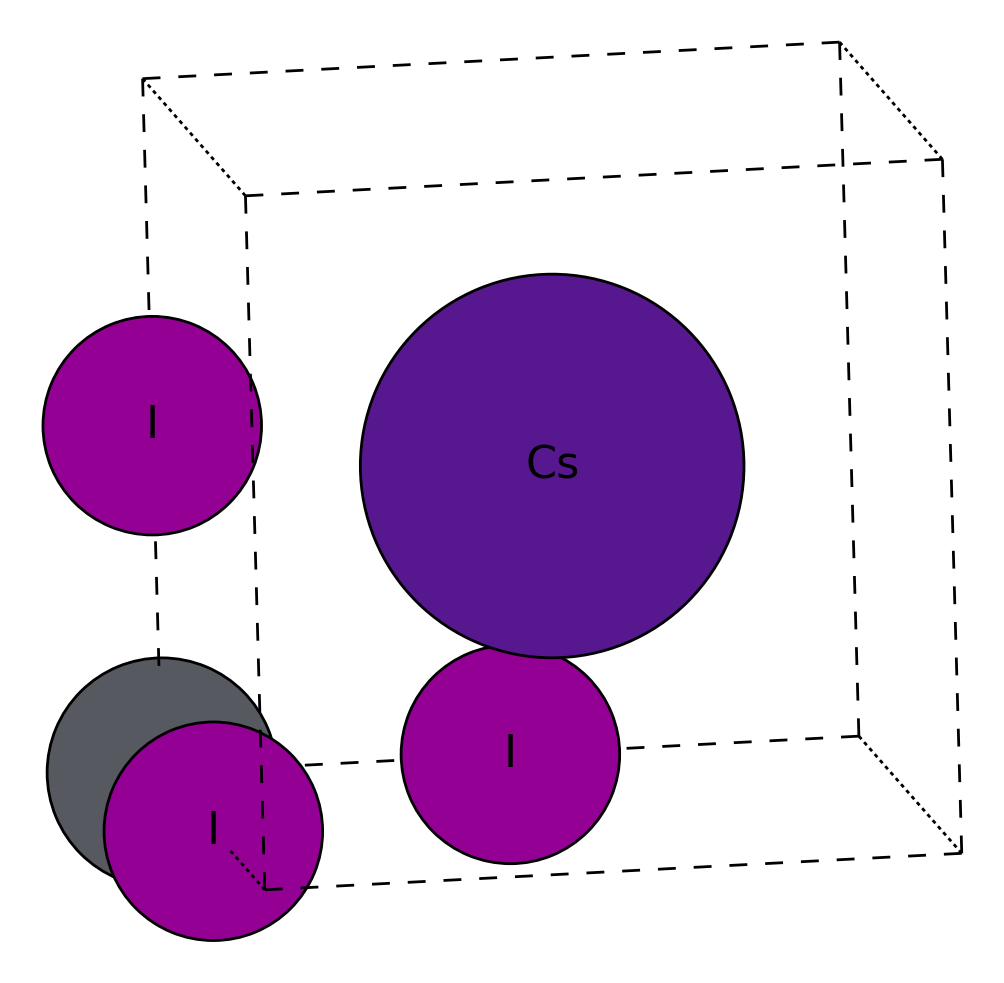

Structure visualisation complete

Species analysis:
Species present in the structure:
  Cs+1: 1 atom(s)
  I-1: 3 atom(s)
  Pb+2: 1 atom(s)

Species as formatted strings: ['Cs1+', 'I1-', 'Pb2+']
Contains Cs+? True
Contains Na+? False


In [22]:
print_section_header("PART 1: STRUCTURE RETRIEVAL AND REPRESENTATION")

# Retrieve CsPbI3 structure from Materials Project
cspbi3_species = [("Cs", 1, 1), ("Pb", 2, 1), ("I", -1, 3)]

print("Retrieving CsPbI₃ structure from Materials Project...")
try:
    if api_key != "YOUR_MP_API_KEY":
        cspbi3_sstruct = SmactStructure.from_mp(species=cspbi3_species, api_key=api_key)
        print("Successfully retrieved structure from Materials Project!")
    else:
        raise ValueError("No API key available")
except Exception as e:
    print(f"Could not retrieve from MP: {e}")
    print("Creating a demo structure instead...")
    cspbi3_sstruct = create_demo_structure()

# Explore the SmactStructure representation
print("\nSmactStructure for CsPbI₃:")
print("=" * 60)
print(cspbi3_sstruct)
print("=" * 60)

print("\nKey features of SmactStructure:")
print("- Includes oxidation states (Cs1+, Pb2+, I1-)")
print("- POSCAR-like format for easy visualisation") 
print("- Preserves crystallographic information")
print("- Compatible with pymatgen Structure objects")

# Visualise the crystal structure
if pymatviz_available:
    try:
        print("\nVisualising CsPbI₃ crystal structure...")
        pmv.structure_2d(cspbi3_sstruct.as_py_struct())
        plt.show()
        print("Structure visualisation complete")
    except Exception as e:
        print(f"Could not visualise structure: {e}")

# Working with species information
print("\nSpecies analysis:")
print("Species present in the structure:")
for spec in cspbi3_sstruct.species:
    element, ox_state, count = spec
    print(f"  {element}{ox_state:+d}: {count} atom(s)")

print(f"\nSpecies as formatted strings: {cspbi3_sstruct.get_spec_strs()}")

# Check for specific species
has_cs = cspbi3_sstruct.has_species(("Cs", 1))
has_na = cspbi3_sstruct.has_species(("Na", 1))
print(f"Contains Cs+? {has_cs}")
print(f"Contains Na+? {has_na}")


## Part 2: The Power of Ion Substitution - CationMutator

Now we'll explore the CationMutator class, which is the engine behind SMACT's structure prediction. It uses lambda tables - databases of ion substitution probabilities based on real crystallographic data.

The key insight: if Ba²⁺ often substitutes for Sr²⁺ in known structures, then a new Ba-containing compound might adopt a known Sr structure!


PART 2: ION SUBSTITUTION WITH CATIONMUTATOR
Loading CationMutator with pymatgen lambda table...
✓ CationMutator loaded successfully

Substitution probability examples:
------------------------------------------------------------
  Ba2+ → Sr2+  : 0.00276 (similar size/charge - alkaline earths)
  Fe2+ → Mn2+  : 0.0002324 (similar transition metals)
  Ba2+ → Li1+  : 2.214e-05 (very different size - should be low)
  Fe3+ → Na1+  : 0.0004027 (different charge/chemistry - should be low)

Higher probability = more chemically reasonable substitution!

Generating substitution candidates for CsPbI₃...
(Using probability threshold of 0.001)

✓ Found 59 possible substitutions!

Top 5 most probable substitutions:
------------------------------------------------------------
 1.   Rb1+ → Cs1+  : p=0.166
     New formula: RbPbI3
 2.   Br1- → I1-   : p=0.139
     New formula: CsPbBr3
 3.   Tl1+ → Cs1+  : p=0.102
     New formula: TlPbI3
 4.    K1+ → Cs1+  : p=0.089
     New formula: KPbI3
 5.   In1+ →

/tmp/ipykernel_474725/364565328.py:92: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


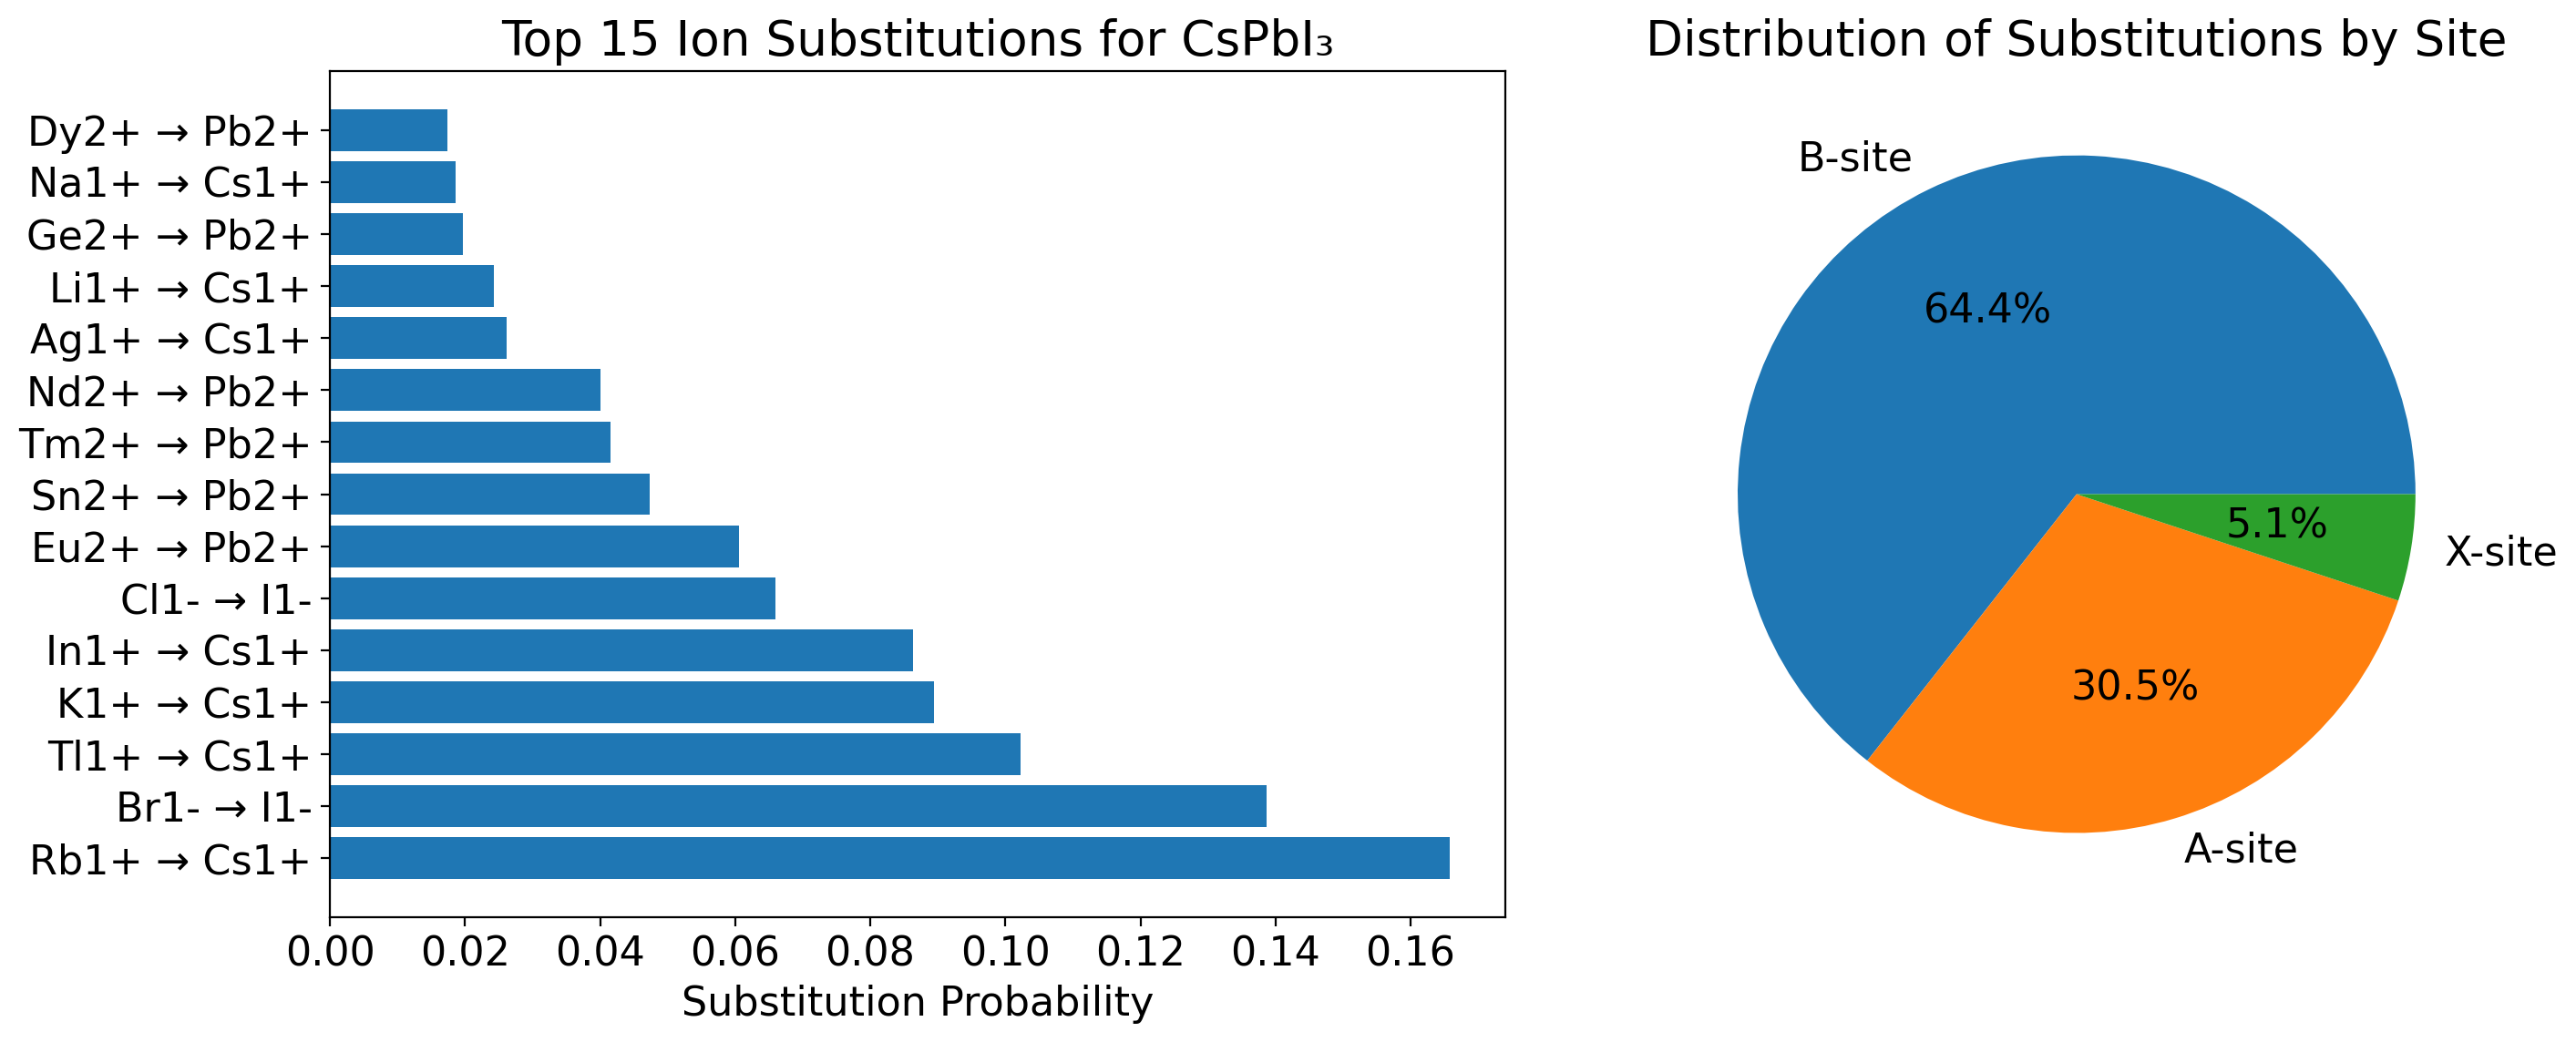

✓ Visualisation complete

Visualising original vs most probable substitution:


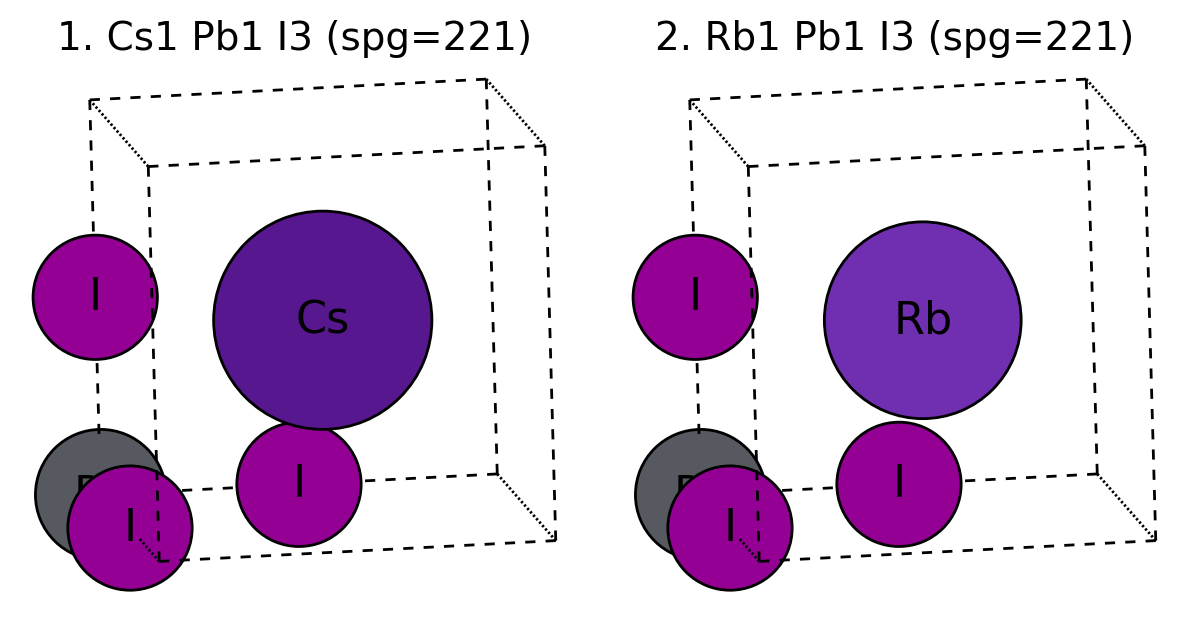

✓ Structure comparison complete


In [23]:
print_section_header("PART 2: ION SUBSTITUTION WITH CATIONMUTATOR")

# Initialise the CationMutator
print("Loading CationMutator with pymatgen lambda table...")
mutator = CationMutator.from_json()
print("✓ CationMutator loaded successfully")

# Explore substitution probabilities
print("\nSubstitution probability examples:")
print("-" * 60)

# Test various ion pairs to demonstrate the concept
test_pairs = [
    ("Ba2+", "Sr2+", "similar size/charge - alkaline earths"),
    ("Fe2+", "Mn2+", "similar transition metals"),
    ("Ba2+", "Li1+", "very different size - should be low"),
    ("Fe3+", "Na1+", "different charge/chemistry - should be low")
]

for ion1, ion2, description in test_pairs:
    prob = mutator.sub_prob(ion1, ion2)
    print(f"{ion1:>6s} → {ion2:<6s}: {prob:.4g} ({description})")

print("\nHigher probability = more chemically reasonable substitution!")

# Generate candidate doped structures
print("\nGenerating substitution candidates for CsPbI₃...")
print("(Using probability threshold of 0.001)")

candidate_structures = list(mutator.unary_substitute(cspbi3_sstruct, thresh=0.001))
print(f"\n✓ Found {len(candidate_structures)} possible substitutions!")

# Analyse the results
if candidate_structures:
    print("\nTop 5 most probable substitutions:")
    print("-" * 60)
    
    # Sort by probability
    sorted_candidates = sorted(candidate_structures, key=lambda x: x[1], reverse=True)
    
    for i, (struct, prob, orig, new) in enumerate(sorted_candidates[:5]):
        print(f"{i+1:2d}. {new:>6s} → {orig:<6s}: p={prob:.3f}")
        print(f"     New formula: {struct.reduced_formula()}")
    
    # Create detailed pandas analysis
    print("\nCreating detailed substitution analysis...")
    
    analysis_data = []
    for struct, prob, orig, new in candidate_structures:
        analysis_data.append({
            'Original Ion': orig,
            'Substitute Ion': new,
            'Probability': prob,
            'New Formula': struct.reduced_formula(),
            'Site Type': 'A-site' if orig == 'Cs1+' else 'B-site' if orig == 'Pb2+' else 'X-site'
        })
    
    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis.sort_values('Probability', ascending=False).reset_index(drop=True)
    
    print("\nSubstitution analysis by site:")
    print("=" * 70)
    
    # Group by original ion (site type)
    for orig_ion in df_analysis['Original Ion'].unique():
        subset = df_analysis[df_analysis['Original Ion'] == orig_ion]
        site_type = subset.iloc[0]['Site Type']
        print(f"\n{site_type} - Top 3 substitutions for {orig_ion}:")
        for _, row in subset.head(3).iterrows():
            print(f"  {row['Substitute Ion']:>6s} → {row['New Formula']:>12s} (p={row['Probability']:.3f})")
    
    # Create visualisation of substitution probabilities
    try:
        print("\nCreating substitution probability visualisation...")
        top_15 = df_analysis.head(15)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Bar plot of top substitutions
        ax1.barh(range(len(top_15)), top_15['Probability'])
        ax1.set_yticks(range(len(top_15)))
        ax1.set_yticklabels([f"{row['Substitute Ion']} → {row['Original Ion']}" 
                            for _, row in top_15.iterrows()])
        ax1.set_xlabel('Substitution Probability')
        ax1.set_title('Top 15 Ion Substitutions for CsPbI₃')
        
        # Site-based analysis
        site_counts = df_analysis['Site Type'].value_counts()
        ax2.pie(site_counts.values, labels=site_counts.index, autopct='%1.1f%%')
        ax2.set_title('Distribution of Substitutions by Site')
        
        plt.tight_layout()
        plt.show()
        print("✓ Visualisation complete")
    except Exception as e:
        print(f"Could not create plots: {e}")
    
    # Visualise structures if possible
    if pymatviz_available:
        try:
            print("\nVisualising original vs most probable substitution:")
            top_struct = sorted_candidates[0][0]
            pmv.structure_2d([cspbi3_sstruct.as_py_struct(), top_struct.as_py_struct()])
            plt.show()
            print("✓ Structure comparison complete")
        except Exception as e:
            print(f"Could not visualise structures: {e}")


## Part 3: Building and Querying Structure Databases
For structure prediction at scale, we need to organize structures in a database. SMACT provides StructureDB - a lightweight SQLite wrapper designed for crystallographic data:

In [24]:
print_section_header("PART 3: STRUCTURE DATABASE MANAGEMENT")

# Create a structure database
print("Setting up structure database...")

# Clean up any existing database
db_filename = "tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database
db = StructureDB(db_filename)

# Add a table for our structures
table_name = "perovskites"
db.add_table(table_name)

print(f"Created database '{db_filename}' with table '{table_name}'")

# Add our structures
print("\nAdding structures to database...")
db.add_struct(cspbi3_sstruct, table=table_name)
print("  - Added CsPbI₃ (original structure)")

# Add substitution candidates
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]  # First 10
    num_added = db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {num_added} substitution variants")

# Add Materials Project perovskites if API key available
mp_table = "mp_perovskites"
try:
    perov_data = get_mp_perovskite_data(api_key, max_structures=20)
    
    if perov_data:
        print(f"\nAdding {len(perov_data)} Materials Project perovskites...")
        db.add_table(mp_table)
        num_mp_added = db.add_mp_icsd(table=mp_table, mp_data=perov_data)
        print(f"Successfully added Materials Project structures to '{mp_table}' table")
        
        # Use the larger database for predictions
        prediction_table = mp_table
    else:
        prediction_table = table_name
        
except Exception as e:
    print(f"Could not add MP data: {e}")
    prediction_table = table_name

# Count total structures in databases
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    local_count = c.fetchone()[0]
    print(f"\nLocal database '{table_name}': {local_count} structures")
    
    if prediction_table == mp_table:
        c.execute(f"SELECT COUNT(*) FROM {mp_table}")
        mp_count = c.fetchone()[0]
        print(f"MP database '{mp_table}': {mp_count} structures")

# Query structures containing specific species
print("\nQuerying database for specific species...")
print("-" * 50)

# Find all structures containing Cs+
cs_structures = db.get_with_species(species=[("Cs", 1)], table=table_name)
print(f"\nStructures containing Cs⁺: {len(cs_structures)}")
for struct in cs_structures[:3]:
    print(f"  - {struct.reduced_formula()}")

# Find structures with both Cs+ and Pb2+
cs_pb_structures = db.get_with_species(species=[("Cs", 1), ("Pb", 2)], table=table_name)
print(f"\nStructures containing both Cs⁺ and Pb²⁺: {len(cs_pb_structures)}")

# Analyse anion distribution if MP data available
if prediction_table == mp_table:
    print(f"\nAnalysing anion distribution in MP perovskites...")
    anions = [("F", -1), ("Cl", -1), ("Br", -1), ("I", -1), ("O", -2), ("S", -2), ("N", -3)]
    anion_counts = {}
    
    for anion_name, ox_state in anions:
        try:
            count = len(db.get_with_species([(anion_name, ox_state)], table=mp_table))
            if count > 0:
                anion_counts[f"{anion_name}{ox_state:+d}"] = count
        except Exception as e:
            print(f"Error querying {anion_name}{ox_state:+d}: {e}")
    
    if anion_counts:
        plt.figure(figsize=(10, 6))
        plt.bar(anion_counts.keys(), anion_counts.values())
        plt.xlabel("Anion")
        plt.ylabel("Number of Structures")
        plt.title("Distribution of Perovskites by Anion Type (Materials Project)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        print("Anion distribution analysis complete")



PART 3: STRUCTURE DATABASE MANAGEMENT
Setting up structure database...
Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃ (original structure)
  - Added 10 substitution variants
Querying Materials Project for up to 20 perovskite structures...


Retrieving RobocrystallogapherDoc documents:   0%|          | 0/8509 [00:00<?, ?it/s]

Found 20 perovskite material IDs, retrieving structures...


Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]


Adding 4 Materials Project perovskites...
Could not add MP data: table mp_perovskites already exists

Local database 'perovskites': 11 structures

Querying database for specific species...
--------------------------------------------------

Structures containing Cs⁺: 1
  - CsPbI3

Structures containing both Cs⁺ and Pb²⁺: 1


## Part 4: Structure Prediction from Composition

Now we combine everything to predict structures for new compositions! The **StructurePredictor** class orchestrates the process:

- Takes a target composition
- Searches the database for structures with similar chemistry
- Tests if ion substitutions can transform them to the target
- Returns candidate structures ranked by substitution probability

In [25]:
print_section_header("PART 4: STRUCTURE PREDICTION FROM COMPOSITION")

# Initialise structure predictor
print(f"Initialising structure predictor with '{prediction_table}' database...")
predictor = StructurePredictor(
    mutator=mutator,
    struct_db=db,
    table=prediction_table
)

# Define target compositions to test
target_compositions = [
    ([("Rb", 1), ("Pb", 2), ("Br", -1)], "RbPbBr₃"),
    ([("K", 1), ("Sn", 2), ("I", -1)], "KSnI₃"),
    ([("Ba", 2), ("Ti", 4), ("O", -2)], "BaTiO₃")
]

print("\nTesting structure prediction for various compositions...")

for target_species, formula in target_compositions:
    print(f"\n--- Target composition: {formula} ---")
    
    # Predict structures
    threshold = 0.001
    results = list(predictor.predict_structs(
        species=target_species,
        thresh=threshold,
        include_same=False
    ))
    
    print(f"Found {len(results)} candidate structures!")
    
    if results:
        # Sort by probability
        results.sort(key=itemgetter(1), reverse=True)
        
        print("Top predictions:")
        for i, (pred_struct, prob, parent_struct) in enumerate(results[:3]):
            print(f"  {i+1}. Parent: {parent_struct.reduced_formula()} → "
                    f"Predicted: {pred_struct.reduced_formula()} (p={prob:.3f})")
            
            # Show key substitutions
            parent_species = set(parent_struct.get_spec_strs())
            pred_species = set(pred_struct.get_spec_strs())
            subs_out = parent_species - pred_species
            subs_in = pred_species - parent_species
            if subs_out and subs_in:
                print(f"      Substitutions: {subs_out} → {subs_in}")
    else:
        print("  No predictions found - try lowering threshold or expanding database")



PART 4: STRUCTURE PREDICTION FROM COMPOSITION
Initialising structure predictor with 'perovskites' database...

Testing structure prediction for various compositions...

--- Target composition: RbPbBr₃ ---
Found 0 candidate structures!
  No predictions found - try lowering threshold or expanding database

--- Target composition: KSnI₃ ---
Found 1 candidate structures!
Top predictions:
  1. Parent: KPbI3 → Predicted: KSnI3 (p=0.012)
      Substitutions: {'Pb2+'} → {'Sn2+'}

--- Target composition: BaTiO₃ ---
Found 0 candidate structures!
  No predictions found - try lowering threshold or expanding database


## Part 5: Advanced Topics - Custom Probability Models

So far we've used empirical lambda tables. SMACT also supports physics-based probability models. The RadiusModel computes substitution probabilities based on ionic radius similarity:

```{tip}
Custom probability models allow you to incorporate domain knowledge into structure prediction. For example, you might weight substitutions differently for high-temperature vs ambient-condition synthesis.
```

In [26]:
print_section_header("PART 5: ADVANCED ANALYSIS AND INSIGHTS")

# Analyse prediction success rate
if candidate_structures:
    print("Ion substitution insights:")
    
    # Analyse by chemical family
    alkali_subs = [c for c in candidate_structures if c[2] == 'Cs1+']
    halide_subs = [c for c in candidate_structures if c[2] == 'I1-']
    metal_subs = [c for c in candidate_structures if c[2] == 'Pb2+']
    
    print(f"- A-site (Cs+) substitutions: {len(alkali_subs)}")
    print(f"- X-site (I-) substitutions: {len(halide_subs)}")
    print(f"- B-site (Pb2+) substitutions: {len(metal_subs)}")
    
    # Most probable by site
    if alkali_subs:
        best_alkali = max(alkali_subs, key=lambda x: x[1])
        print(f"- Best A-site substitution: {best_alkali[3]} (p={best_alkali[1]:.3f})")
    
    if halide_subs:
        best_halide = max(halide_subs, key=lambda x: x[1])
        print(f"- Best X-site substitution: {best_halide[3]} (p={best_halide[1]:.3f})")
    
    if metal_subs:
        best_metal = max(metal_subs, key=lambda x: x[1])
        print(f"- Best B-site substitution: {best_metal[3]} (p={best_metal[1]:.3f})")

# Chemical insights
print("Chemical insights from this tutorial:")
print("1. Alkali metals (Rb+, K+) readily substitute for Cs+ due to similar chemistry")
print("2. Halides (Br-, Cl-) can substitute for I- while maintaining structure")
print("3. Divalent metals (Eu2+, Sn2+) can replace Pb2+ with varying probability")
print("4. Structure prediction works by finding chemically similar parent structures")
print("5. Larger databases provide more parent structures and better predictions")



PART 5: ADVANCED ANALYSIS AND INSIGHTS
Ion substitution insights:
- A-site (Cs+) substitutions: 18
- X-site (I-) substitutions: 3
- B-site (Pb2+) substitutions: 38
- Best A-site substitution: Rb1+ (p=0.166)
- Best X-site substitution: Br1- (p=0.139)
- Best B-site substitution: Eu2+ (p=0.061)
Chemical insights from this tutorial:
1. Alkali metals (Rb+, K+) readily substitute for Cs+ due to similar chemistry
2. Halides (Br-, Cl-) can substitute for I- while maintaining structure
3. Divalent metals (Eu2+, Sn2+) can replace Pb2+ with varying probability
4. Structure prediction works by finding chemically similar parent structures
5. Larger databases provide more parent structures and better predictions


In [27]:
print(f"\nFinal statistics:")
print(f"- Original structure: CsPbI₃ with {len(cspbi3_sstruct.species)} unique species")
if 'candidate_structures' in locals():
    print(f"- Substitution candidates generated: {len(candidate_structures)}")
print(f"- Local database size: {local_count} structures")
if prediction_table == mp_table:
    print(f"- Materials Project database size: {mp_count} structures")

total_predictions = 0
for target_species, formula in target_compositions:
    results = list(predictor.predict_structs(species=target_species, thresh=0.001, include_same=False))
    total_predictions += len(results)
print(f"- Total structure predictions made: {total_predictions}")

# Clean up
if os.path.exists(db_filename):
    os.remove(db_filename)
    print(f"\nCleaned up database file: {db_filename}")

if __name__ == "__main__":
    main()


Final statistics:
- Original structure: CsPbI₃ with 3 unique species
- Substitution candidates generated: 59
- Local database size: 11 structures
- Total structure predictions made: 1

Cleaned up database file: tutorial_structures.db


## Summary: Your Structure Prediction Toolkit

Congratulations! You've mastered SMACT's structure prediction framework. Let's recap what you've learned:

### 🎯 Key Skills Acquired

1. **Structure Representation**

   - Loading structures from multiple sources

   - Working with oxidation states in crystal structures

   - Converting between different structure formats

2. **Ion Substitution Chemistry**

   - Understanding substitution probabilities

   - Generating doped structures systematically

   - Analysing chemical substitution patterns

3. **Database Management**

   - Building structure databases

   - Querying by chemical criteria

   - Integrating with Materials Project

4. **Structure Prediction**

   - Predicting structures for new compositions

   - Understanding parent-child structure relationships

   - Ranking predictions by probability

5. **Advanced Techniques**

   - Comparing different probability models

   - Customizing prediction workflows

   - Scaling to large databases

### 🚀 Next Steps

Now that you understand structure prediction, you can:

1. **Build specialised databases** for your research area

2. **Develop custom probability models** based on your synthesis conditions

3. **Integrate with DFT calculations** to validate predictions

4. **Create high-throughput screening pipelines** for new materials

### 💡 Pro Tips

- Start with well-curated databases (like Materials Project)

- Use multiple probability models to cross-validate predictions

- Consider chemical intuition when setting probability thresholds

- Validate promising predictions with additional calculations

### 📚 Resources

- [SMACT Documentation](https://smact.readthedocs.io/)

- [Materials Project](https://materialsproject.org/)

- [Pymatgen Documentation](https://pymatgen.org/)

```{tip}
Remember: structure prediction is both an art and a science. The more chemical knowledge you bring, the better your predictions will be!
```